In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.mortality.final_model_loss_train_mortality import *
from model.final_model.mortality.final_model_mortality import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.mortality.plot import *


import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===

test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

test_loader = DataLoader(dataset_test,batch_size=8 ,collate_fn=collate_fn, shuffle=False)


Built 461 patient-tree graphs


In [3]:
flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [4]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_30/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

# Feature Importance Analysis

In [5]:
from captum.attr import IntegratedGradients

In [6]:
test_input = next(iter(test_loader))
_, flat_data, ts_data, graph_data, risk, ts_lengths, categories, mortality, _ = test_input

flat_data = flat_data.to(device)
flat_data.requires_grad = True
ts_data = ts_data.to(device)
ts_data.requires_grad = True
graph_data = graph_data.to(device)
graph_data.requires_grad = True

risk = risk.to(device)
ts_lengths = ts_lengths.to(device)
categories = categories.to(device)
mortality = mortality.to(device)

In [17]:
graph_data[0]

Data(x=[9, 62], edge_index=[2, 46], patient_id=[1], node_names=[9], mask=[9])

In [7]:
def forward_flat(flat_input):
    B = flat_input.size(0)  #
    T = ts_data.size(1)

    # flat
    flat_emb = model.flat_encoder(flat_input)

    # ts
    ts_emb = model.ts_encoder(ts_data.repeat(B // ts_data.size(0), 1, 1), 
                               ts_lengths.repeat(B // ts_lengths.size(0)))

    # lstm
    output, _ = model.mortality_predictor.lstm(ts_emb)
    ts_out = model.mortality_predictor.fc_ts(output)

    # flat-fc
    fused_out = model.mortality_predictor.fc_fused(flat_emb)
    fused_out_exp = fused_out.unsqueeze(1).expand(-1, T, -1)

    combine_exp = torch.cat([fused_out_exp, ts_out], dim=2)
    combine_out = model.mortality_predictor.fc_combine(combine_exp)

    return torch.sigmoid(combine_out).squeeze(-1).mean(dim=1)  

ig_flat = IntegratedGradients(forward_flat)

flat_attr = ig_flat.attribute(flat_data)

In [8]:
with open('/home/mei/nas/docker/thesis/data/hdf/flat_features.txt', 'r') as f:
    features = [line.strip() for line in f]

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_attribution(
    attr_tensor, 
    feature_names, 
    sample_idx=None, 
    top_k=None,
    title=None
):

    # 选择单个样本 or 全局
    if sample_idx is not None:
        attr = attr_tensor[sample_idx].detach().cpu().numpy()
        plot_title = f"Feature Attribution for Sample {sample_idx}"
    else:
        attr = attr_tensor.abs().mean(dim=0).detach().cpu().numpy()
        plot_title = "Flat Feature Attribution"

    if title is not None:
        plot_title = title

    # 排序
    sorted_idx = np.argsort(-np.abs(attr))

    if top_k is not None:
        sorted_idx = sorted_idx[:top_k]

    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_values = [attr[i] for i in sorted_idx]

    # 绘制
    plt.figure(figsize=(8, max(4, len(sorted_idx) * 0.4)))
    plt.barh(sorted_features, sorted_values, color='steelblue')
    plt.xlabel('Attribution')
    plt.title(plot_title)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

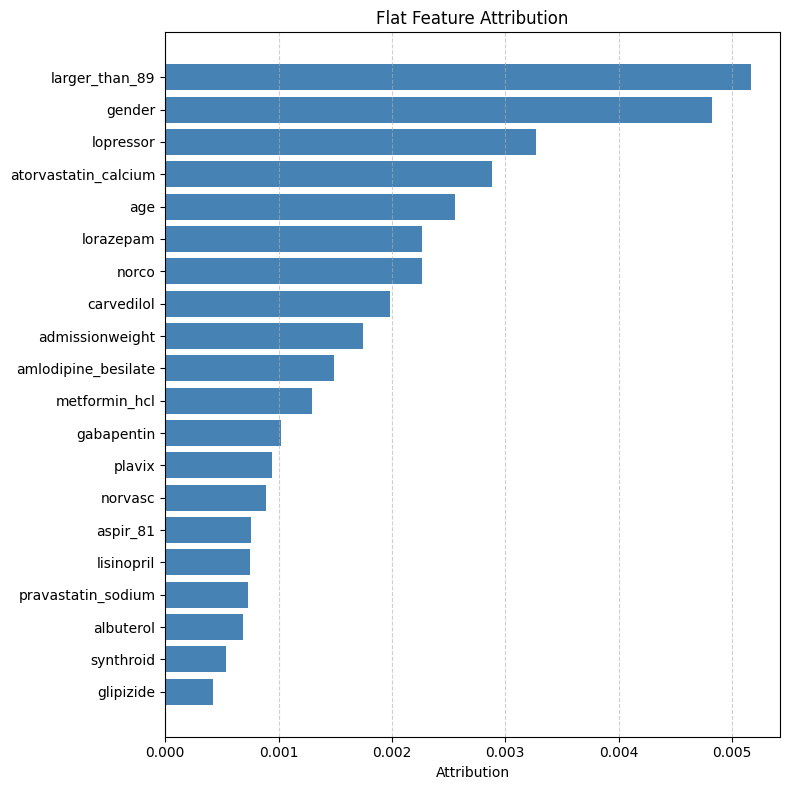

In [12]:
plot_feature_attribution(
    attr_tensor=flat_attr,
    feature_names=features,
    top_k=20
)

In [ ]:
from torch_scatter import scatter_mean

def forward_ts(ts_input, ts_lengths, flat_data, graph_data):
    # Fused static features
    flat_emb = model.flat_encoder(flat_data)
    
    graph_x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch
    node_emb = model.graph_encoder(graph_x, edge_index)
    mask = graph_data.mask.unsqueeze(-1)
    graph_emb = scatter_mean(node_emb * mask, batch, dim=0)
    
    fused_emb = model.fusion([flat_emb, graph_emb])

    # TimeSeries
    ts_emb = model.ts_encoder(ts_input, ts_lengths)

    output, _ = model.mortality_predictor.lstm(ts_emb)
    ts_out = model.mortality_predictor.fc_ts(output)

    fused_out = model.mortality_predictor.fc_fused(fused_emb)
    fused_out_exp = fused_out.unsqueeze(1).expand(-1, ts_input.size(1), -1)

    combine_exp = torch.cat([fused_out_exp, ts_out], dim=2)
    combine_out = model.mortality_predictor.fc_combine(combine_exp)

    return torch.sigmoid(combine_out).squeeze(-1).mean(dim=1)


ig = IntegratedGradients(forward_ts)

ts_attr = ig.attribute(
    ts_data,
    additional_forward_args=(ts_lengths, flat_data, graph_data),
    n_steps=20,
    internal_batch_size=8
)

In [ ]:
attr_mean_per_feature = ts_attr.abs().mean(dim=(0, 1)).detach().cpu().numpy()

with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    ts_features = [line.strip() for line in f]


def plot_ts_feature_attribution(
    attr_tensor, 
    feature_names, 
    top_k=None, 
    title=None
):


    # 聚合：在batch和时间步维度上求平均
    attr_mean = attr_tensor.abs().mean(dim=(0, 1)).detach().cpu().numpy()

    # 排序
    sorted_idx = np.argsort(-attr_mean)

    if top_k is not None:
        sorted_idx = sorted_idx[:top_k]

    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_values = [attr_mean[i] for i in sorted_idx]

    # 绘图
    plt.figure(figsize=(8, max(4, len(sorted_idx) * 0.4)))
    plt.barh(sorted_features, sorted_values, color='powderblue')
    plt.xlabel('Attribution')
    plt.title(title if title else 'TS Feature Attribution (Global)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    


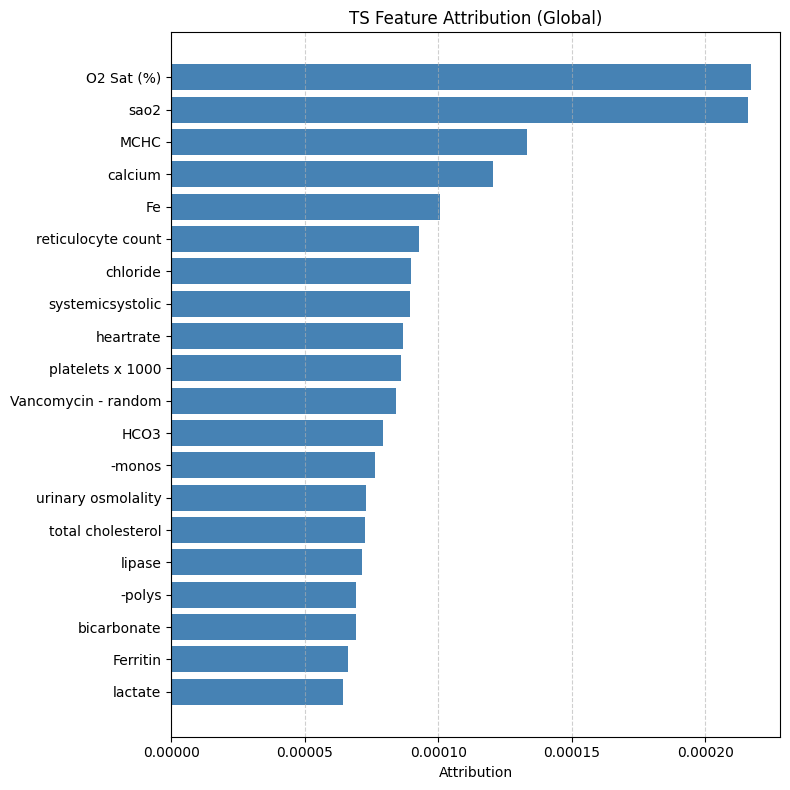

In [23]:
plot_ts_feature_attribution(
    attr_tensor=ts_attr,
    feature_names=ts_features,
    top_k=20
)

In [26]:
def forward_graph_embedding(graph_emb):
    # flat encoder
    flat_emb = model.flat_encoder(flat_data)

    # fuse
    fused_emb = model.fusion([flat_emb, graph_emb])

    # ts encoder
    ts_emb = model.ts_encoder(ts_data, ts_lengths)

    output = model.mortality_predictor(fused_emb, ts_emb, ts_lengths)

    return output.mean(dim=1)

graph_x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch
node_emb = model.graph_encoder(graph_x, edge_index)
mask = graph_data.mask.unsqueeze(-1)
graph_emb = scatter_mean(node_emb * mask, batch, dim=0)  # Shape: [B, D]

241 --- torch.Size([2, 106])
99 --- torch.Size([2, 106])
41 torch.Size([2, 106])
EDGE_INDEX: torch.Size([2, 106])		LOOP_INDEX: torch.Size([2, 41])
241 --- torch.Size([2, 106])
99 --- torch.Size([2, 106])
41 torch.Size([2, 106])
EDGE_INDEX: torch.Size([2, 106])		LOOP_INDEX: torch.Size([2, 41])


In [27]:
ig = IntegratedGradients(forward_graph_embedding)

graph_attr = ig.attribute(
    graph_emb,
    n_steps=20,
    internal_batch_size=8
)

In [ ]:
attr_mean = graph_attr.abs().mean(dim=0).detach().cpu().numpy()

def plot_graph_embedding_attribution(
    attr_tensor, 
    embedding_dim_names=None, 
    top_k=None, 
    title=None
):
    D = attr_tensor.shape[1]
    
    if embedding_dim_names is None:
        embedding_dim_names = [f"Dim {i}" for i in range(D)]

    # 聚合
    attr_mean = attr_tensor.abs().mean(dim=0).detach().cpu().numpy()

    # 排序
    sorted_idx = np.argsort(-attr_mean)

    if top_k is not None:
        sorted_idx = sorted_idx[:top_k]

    sorted_features = [embedding_dim_names[i] for i in sorted_idx]
    sorted_values = [attr_mean[i] for i in sorted_idx]

    # 绘图
    plt.figure(figsize=(8, max(4, len(sorted_idx) * 0.4)))
    plt.barh(sorted_features, sorted_values, color='moccasin')
    plt.xlabel('Attribution')
    plt.title(title if title else 'Graph Embedding Attribution')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
        #'mistyrose', 'moccasin', 'powderblue'

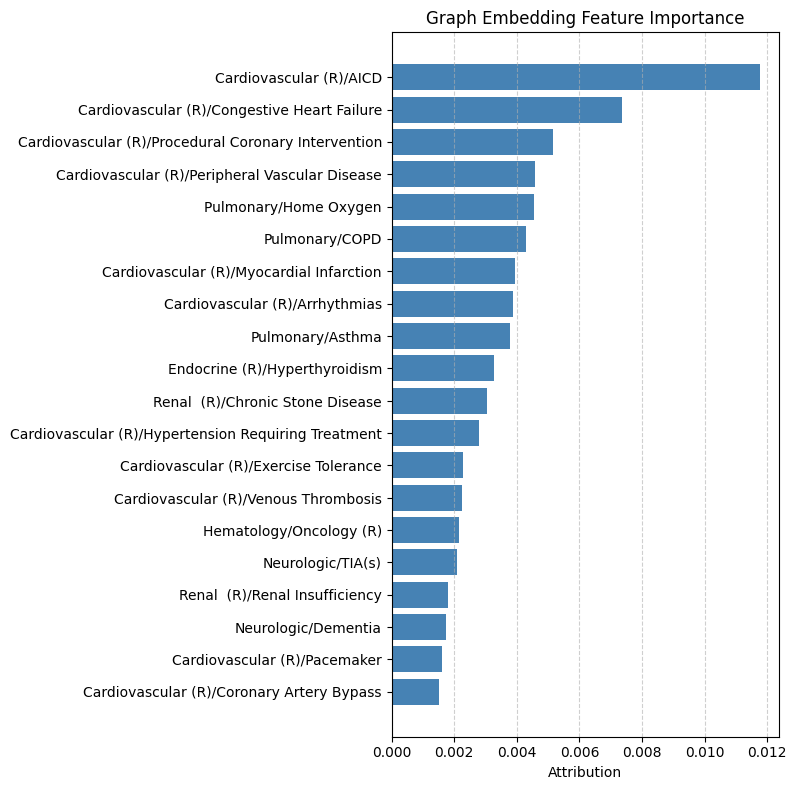

In [31]:
# embedding_dim_names = [f"Dim {i}" for i in range(graph_attr.shape[1])]

with open('/home/mei/nas/docker/thesis/data/hdf/diagnosis_features.txt', 'r') as f:
    diag_features = [line.strip() for line in f]

plot_graph_embedding_attribution(
    attr_tensor=graph_attr,
    embedding_dim_names=diag_features,
    top_k=20,
    title="Graph Embedding Feature Importance"
)

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch_scatter import scatter_mean


def forward_for_contribution(flat_emb, graph_emb, ts_emb_seq, ts_lengths):
    # === Flat + Graph 融合 ===
    fused = model.fusion([flat_emb, graph_emb])  # [B, 32]

    # === LSTM on TS ===
    packed_output = pack_padded_sequence(ts_emb_seq, ts_lengths.cpu(), batch_first=True, enforce_sorted=False)
    packed_output, _ = model.mortality_predictor.lstm(packed_output)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)  # [B, T, hidden_dim]

    ts_out = model.mortality_predictor.fc_ts(output)  # [B, T, 64]
    ts_out = model.mortality_predictor.drop(ts_out)

    fused_out = model.mortality_predictor.fc_fused(fused)  # [B, 64]
    fused_out = model.mortality_predictor.drop(fused_out)

    fused_out_exp = fused_out.unsqueeze(1).expand(-1, ts_out.size(1), -1)  # [B, T, 64]

    combine_exp = torch.cat([fused_out_exp, ts_out], dim=2)  # [B, T, 128]
    combine_out = model.mortality_predictor.fc_combine(combine_exp)  # [B, T, 1]

    output = torch.sigmoid(combine_out).squeeze(-1).mean(dim=1)  # [B]
    return output


def plot_module_contribution(contribution_dict):

    labels = list(contribution_dict.keys())
    values = list(contribution_dict.values())

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color=['mistyrose', 'moccasin', 'powderblue'])
    plt.ylabel('Attribution (L1 Sum)')
    plt.title('Embedding Module Contribution')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

In [ ]:
from captum.attr import IntegratedGradients
model.eval()
flat_emb = model.flat_encoder(flat_data)  # [B, 32]

graph_x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch
node_emb = model.graph_encoder(graph_x, edge_index)
mask = graph_data.mask.unsqueeze(-1)
graph_emb = scatter_mean(node_emb * mask, batch, dim=0)  # [B, 32]

ts_emb = model.ts_encoder(ts_data, ts_lengths)  # [B, T, 128]
ts_emb_pooled = ts_emb.mean(dim=1)  # (B, 128)

241 --- torch.Size([2, 106])
99 --- torch.Size([2, 106])
41 torch.Size([2, 106])
EDGE_INDEX: torch.Size([2, 106])		LOOP_INDEX: torch.Size([2, 41])
241 --- torch.Size([2, 106])
99 --- torch.Size([2, 106])
41 torch.Size([2, 106])
EDGE_INDEX: torch.Size([2, 106])		LOOP_INDEX: torch.Size([2, 41])


In [ ]:
model.train()  # 避免 cuDNN RNN backward 报错

ig = IntegratedGradients(forward_for_contribution)

attributions = ig.attribute(
    inputs=(flat_emb, graph_emb, ts_emb),   # 三个embedding
    additional_forward_args=(ts_lengths,),  #
    n_steps=50
)

flat_attr, graph_attr, ts_attr = attributions

In [26]:
flat_contribution = flat_attr.abs().sum().item()
graph_contribution = graph_attr.abs().sum().item()
ts_contribution = ts_attr.abs().sum().item()

contribution = {
    'Flat': flat_contribution,
    'Graph': graph_contribution,
    'TS': ts_contribution
}

print(contribution)

{'Flat': 0.23079240445216304, 'Graph': 0.7766012741635682, 'TS': 4.226573811312403}


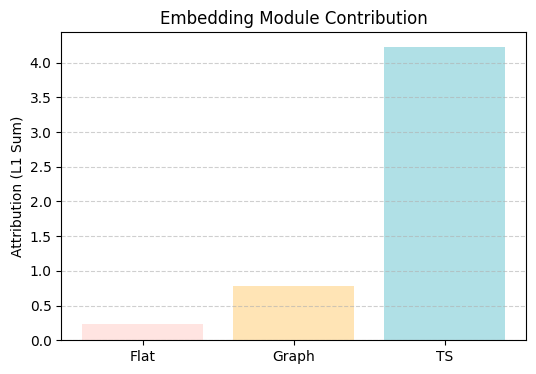

In [ ]:
plot_module_contribution(contribution)